In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
import sklearn.metrics

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [2]:
folder_dir =  'data/'
#folder_dir =  '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

#=data.head(500)

In [3]:
data.shape

(3878118, 25)

In [4]:
data.isnull().any()[data.isnull().any()]

outcome    True
nasty      True
dtype: bool

In [5]:
### Create features
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'zone',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed'],
      dtype='object')

### Generate distance,speed diff, catgorize pitch type

In [6]:
data['dist']=np.sqrt(data['px']**2+data['pz']**2)
data['speed_diff']=data['rolling_start_speed']-data['long_rolling_start_speed']

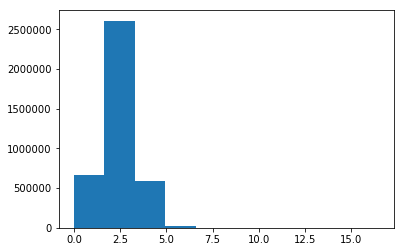

In [7]:
plt.hist(data['dist']);

In [8]:
data['pitch_type'].unique()

array(['FF', 'FS', 'SL', 'CU', 'CH', 'FC', 'KC', 'FT', 'SI'], dtype=object)

In [9]:
#a0.to_numeric(data['pitch_type'],errors='coerce')

In [10]:
pitch_types=pd.get_dummies(data['pitch_type'],prefix='pitch_type')
data=pd.concat([data,pitch_types],axis=1)
pitch_types=0

In [11]:
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'zone',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'dist', 'speed_diff', 'pitch_type_CH',
       'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS',
       'pitch_type_FT', 'pitch_type_KC', 'pitch_type_SI', 'pitch_type_SL'],
      dtype='object')

# Train test split

In [34]:
def split_data(data_new):
    model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir','pitch_count','balls','strikes','date',
             'y','speed_diff']
    data_new["date"] = pd.to_datetime(data_new["date"])

    start = data_new["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
    #start
    end = data_new["date"].searchsorted(datetime.datetime(2016, 1, 1))[0] - 1
    #end

    X_train = data_new[model_feats].loc[start:end]
    y_train=X_train['y']
    X_train=X_train.drop(['y','date'],axis=1)

    X_test=data_new[model_feats][end:]
    y_test=X_test['y']
    X_test=X_test.drop(['y','date'],axis=1)
    return X_train, y_train, X_test, y_test

In [38]:
def random_forest(data):

    X_train, y_train, X_test, y_test = split_data(data_CH)

    steps= [('rf', RandomForestClassifier(oob_score=True))]

    mypipeline= Pipeline(steps)

    param_grid_rf = dict(
    #rf__min_samples_leaf= np.logspace(4, 5, num=5, base=4, endpoint=False, dtype=int),
    #rf__min_samples_split= [100, 1000],
    rf__max_depth= [8],
    rf__n_estimators=[10]
    )

    rf_grid_search= GridSearchCV(mypipeline, 
                     param_grid = param_grid_rf, 
                     scoring = 'neg_log_loss',
                            n_jobs=-1, refit=True)

    rf_grid_search.fit(X_train, y_train)

    best_1 = rf_grid_search.best_score_
    print(best_1)
    rf_grid_search.best_estimator_
    model=rf_grid_search.best_estimator_.steps[0][1]
    print(model)

    probs=model.predict_proba(X_test)[:,1]
    preds=model.predict(X_test)
    baseline_loss=sklearn.metrics.log_loss(y_test,probs)
    baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
    majority_class=np.amax(y_test.value_counts(normalize=True))

    print('%s: %0.3f, %s: %0.3f, %s: %0.3f '
    %('Model accuracy',baseline_acc,'Model log loss', baseline_loss,'Majority class',majority_class))

    # RF Feature Importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances
    fig = plt.figure(figsize=(20,8))
    plt.bar(range(len(indices)), importances[indices], color="r", align="center")
    plt.title('Feature Importances Bar Plot')
    plt.xlabel('Feature Name')
    plt.ylabel('Feature Importance')
    plt.xticks(range(len(indices)), X_train.columns[indices], rotation=45, horizontalalignment='right')
    plt.xlim([-1, len(indices)])
    plt.title('Feature Importance Graph for RF')
    plt.show()

# pitch_type_CH

In [12]:
data_CH = data.loc[data['pitch_type_CH'] == 1]

In [14]:
majority_class=np.amax(data_CH['y'].value_counts(normalize=True))
majority_class

0.53714479626673106

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.519965567873
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.753, Model log loss: 0.527, Majority class: 0.515 


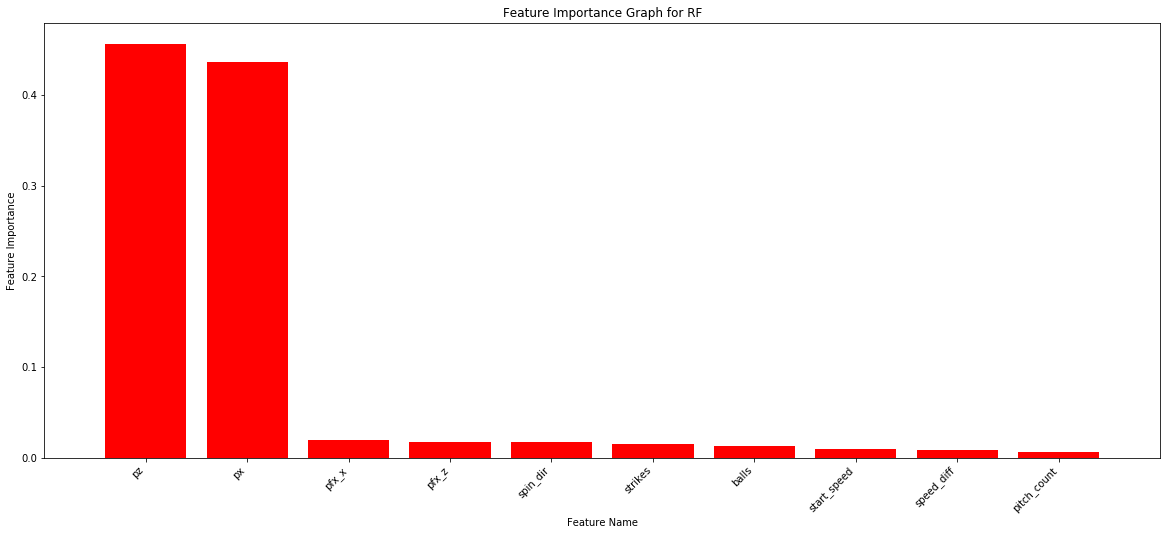

In [39]:
random_forest(data_CH)

# pitch_type_CU

In [18]:
data_CU = data.loc[data['pitch_type_CU'] == 1]
majority_class=np.amax(data_CU['y'].value_counts(normalize=True))
majority_class

0.52689239273823729

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.522315148352
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.749, Model log loss: 0.531, Majority class: 0.515 


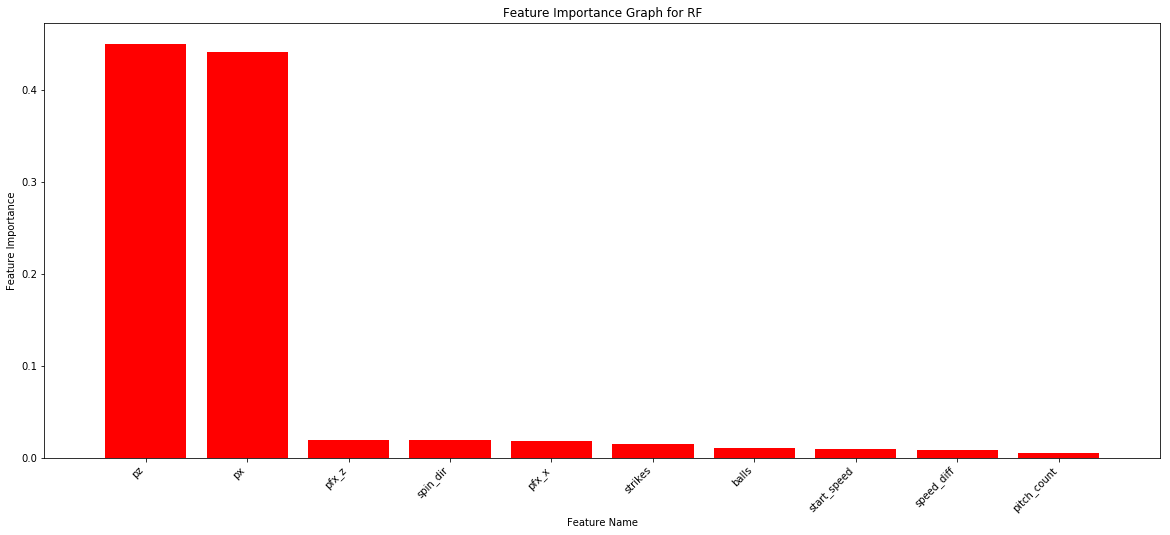

In [40]:
random_forest(data_CU)

# pitch_type_FC

In [19]:
data_FC = data.loc[data['pitch_type_FC'] == 1]
majority_class=np.amax(data_FC['y'].value_counts(normalize=True))
majority_class

0.56692627032349752

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.522470954781
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.752, Model log loss: 0.535, Majority class: 0.515 


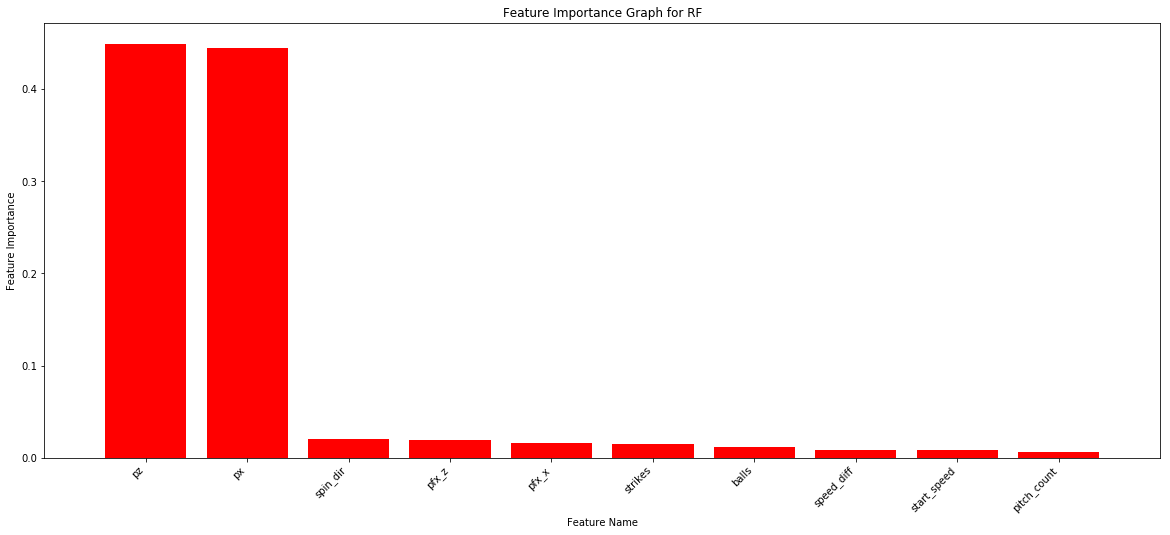

In [41]:
random_forest(data_FC)

# pitch_type_FF

In [20]:
data_FF = data.loc[data['pitch_type_FF'] == 1]
majority_class=np.amax(data_FF['y'].value_counts(normalize=True))
majority_class

0.57009551440251693

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.52075946309
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.750, Model log loss: 0.537, Majority class: 0.515 


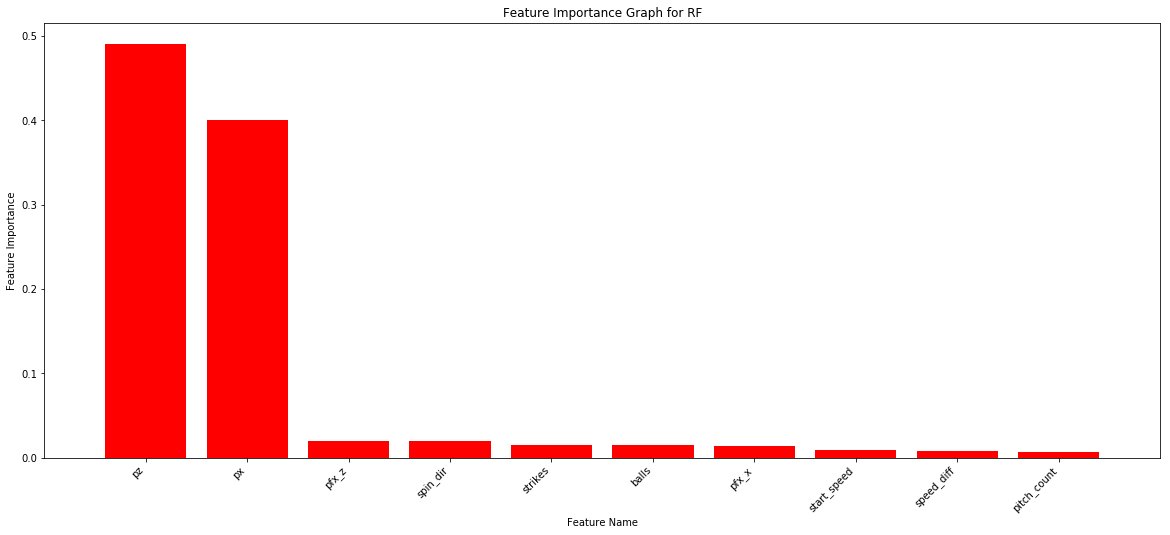

In [42]:
random_forest(data_FF)

# pitch_type_FS

In [21]:
data_FS = data.loc[data['pitch_type_FS'] == 1]
majority_class=np.amax(data_FS['y'].value_counts(normalize=True))
majority_class

0.54088798952505657

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.523666191616
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.748, Model log loss: 0.544, Majority class: 0.515 


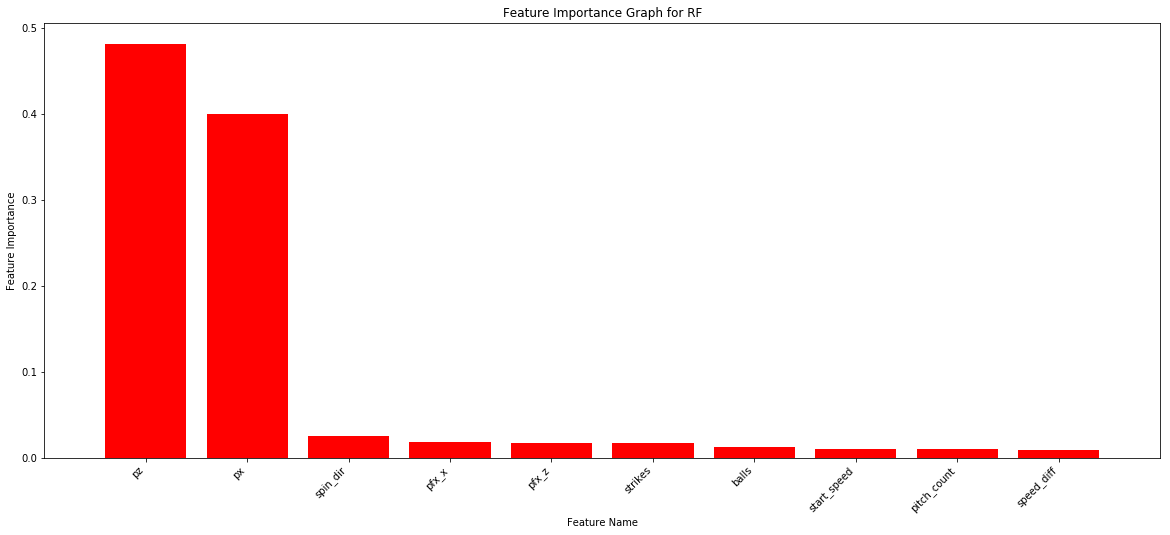

In [43]:
random_forest(data_FS)

# pitch_type_FT

In [22]:
data_FT = data.loc[data['pitch_type_FT'] == 1]
majority_class=np.amax(data_FT['y'].value_counts(normalize=True))
majority_class

0.54323546069035522

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.527783720959
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.746, Model log loss: 0.537, Majority class: 0.515 


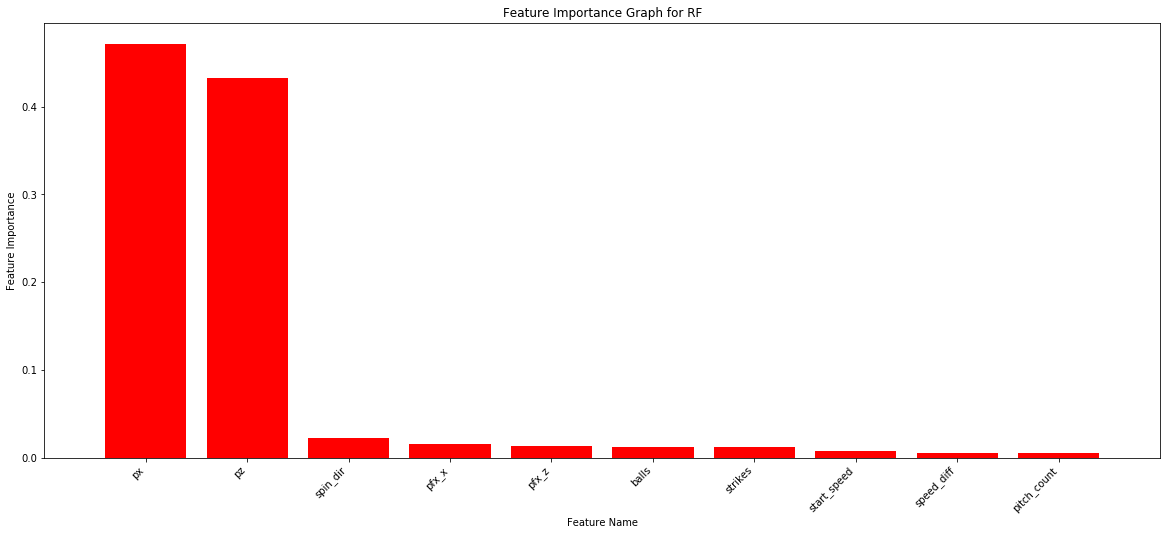

In [44]:
random_forest(data_FT)

# pitch_type_KC

In [23]:
data_KC = data.loc[data['pitch_type_KC'] == 1]
majority_class=np.amax(data_KC['y'].value_counts(normalize=True))
majority_class

0.53309283240151195

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.518602058317
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.750, Model log loss: 0.538, Majority class: 0.515 


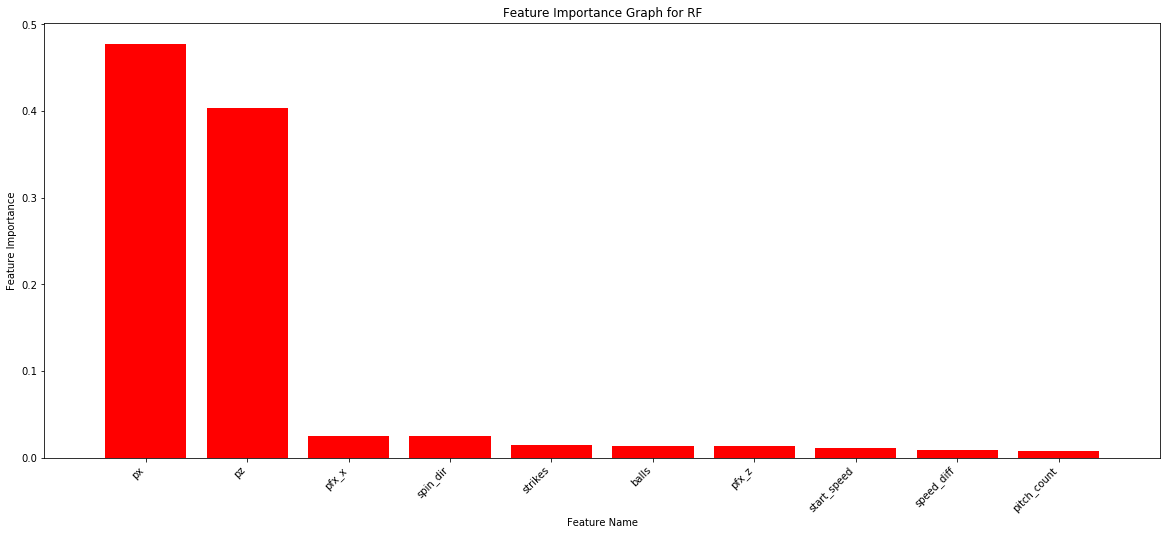

In [45]:
random_forest(data_KC)

# pitch_type_SI

In [24]:
data_SI = data.loc[data['pitch_type_SI'] == 1]
majority_class=np.amax(data_SI['y'].value_counts(normalize=True))
majority_class

0.55094956095568715

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.51810134432
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.751, Model log loss: 0.531, Majority class: 0.515 


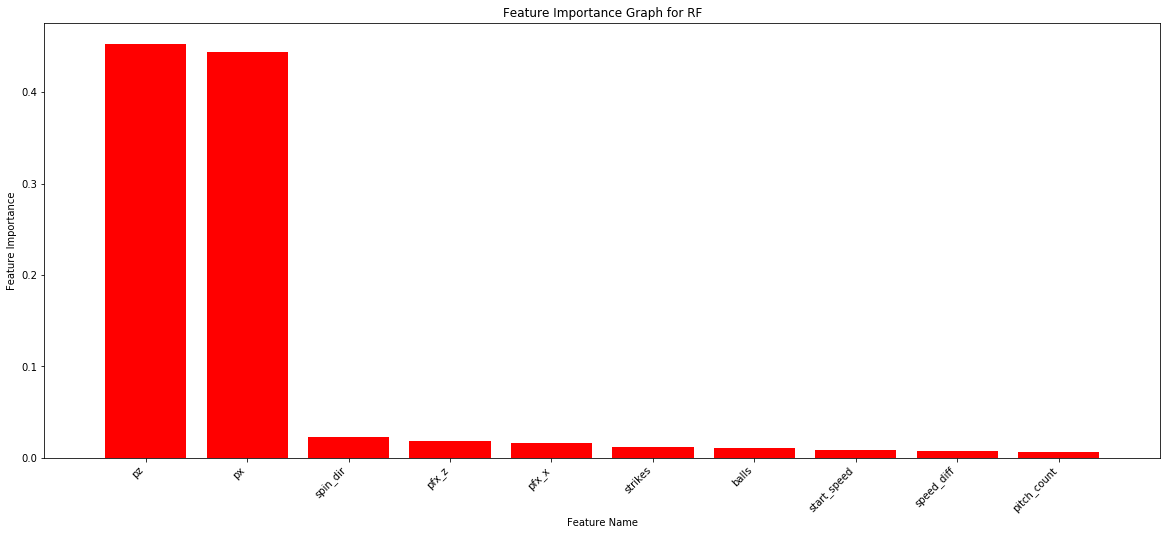

In [46]:
random_forest(data_SI)

# pitch_type_SL

In [25]:
data_SL = data.loc[data['pitch_type_SL'] == 1]
majority_class=np.amax(data_SL['y'].value_counts(normalize=True))
majority_class

0.56179454958678343

/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:457: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/groupm/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:452: UserWarning: Some inputs do not have OOB

-0.515330891828
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
Model accuracy: 0.753, Model log loss: 0.528, Majority class: 0.515 


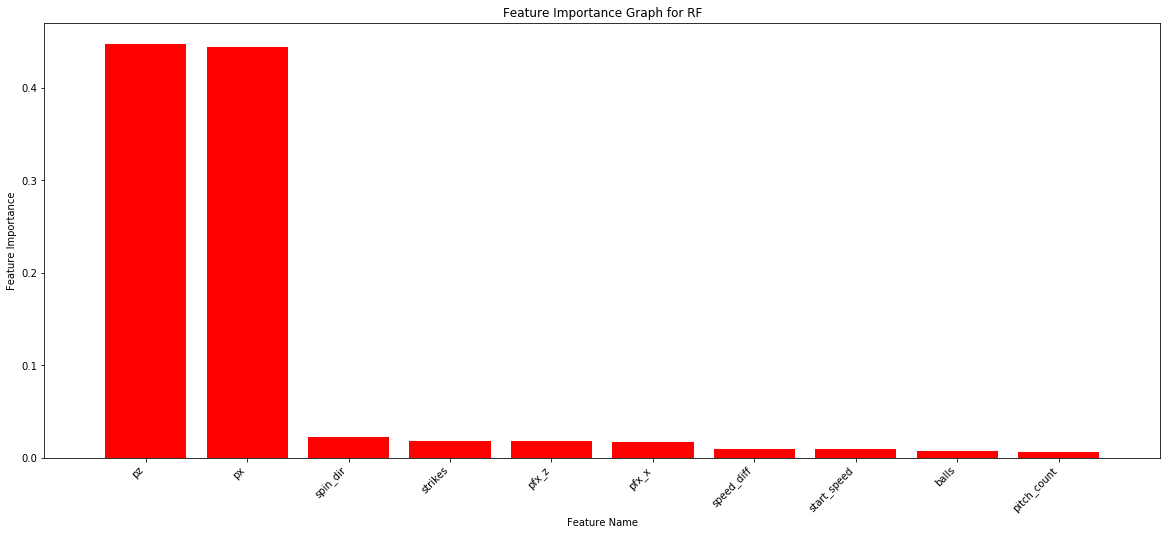

In [47]:
random_forest(data_SL)